In [233]:
import scipy.io 
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import pi
import omp


In [14]:
import cv2
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift

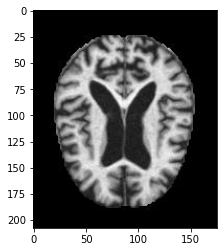

In [15]:
image= cv2.imread('moderateDem44.jpg', 0)/255.
plt.imshow(image, 'gray')

Text(0.5, 1.0, 'Log Fourier Transform')

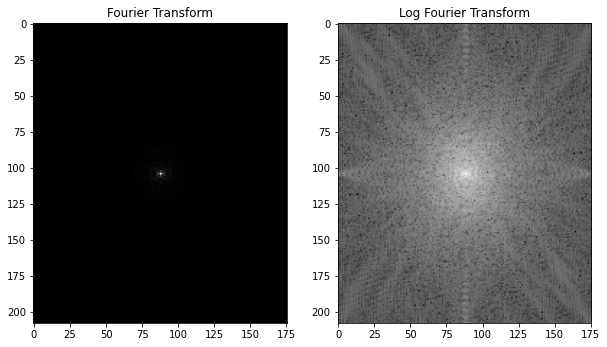

In [21]:
fourier_transform= fftshift(fft2(image))
log_ft= np.log10(abs(fourier_transform))

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(abs(fourier_transform), cmap='gray')
ax[0].set_title("Fourier Transform")
ax[1].imshow(log_ft, cmap='gray')
ax[1].set_title("Log Fourier Transform")

#### Sampling only Low Frequencies

In [187]:
def get_low_freq_mask(height, width, sample_width, sampling_mode='horizontal'):
    kspace_masklines = np.zeros((height, width))
    if sampling_mode is 'horizontal':
        kspace_masklines[height//2-sample_width//2: height//2 + sample_width//2+1]=1
    elif sampling_mode is 'vertical':
        kspace_masklines[:, width//2-sample_width//2: width//2 + sample_width//2+1]=1
    elif sampling_mode is 'central':
        kspace_masklines[height//2-sample_width//2: height//2 + sample_width//2+1, width//2-sample_width//2: width//2 + sample_width//2+1] = 1
    return kspace_masklines

Text(0.5, 1.0, 'Zero Order Reconstruction (Central)')

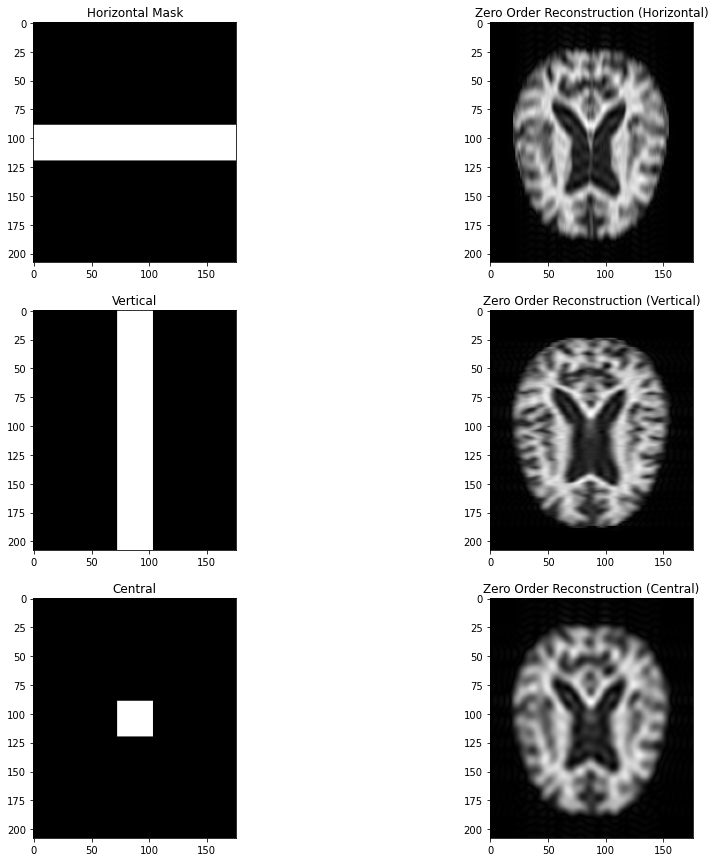

In [190]:
h, w= image.shape
N= 30

mask_1= get_low_freq_mask(h, w, N)
mask_2= get_low_freq_mask(h, w, N, sampling_mode='vertical')
mask_3= get_low_freq_mask(h, w, N, sampling_mode='central')

masked_ft_1= fourier_transform*mask_1
zero_ord_1= abs(ifft2(masked_ft_1))

masked_ft_2= fourier_transform*mask_2
zero_ord_2= abs(ifft2(masked_ft_2))

masked_ft_3= fourier_transform*mask_3
zero_ord_3= abs(ifft2(masked_ft_3))

fig, ax = plt.subplots(3, 2, figsize=(15,15))
ax[0,0].imshow(mask_1, cmap='gray')
ax[0,0].set_title("Horizontal Mask")

ax[0,1].imshow(zero_ord_1, cmap='gray')
ax[0,1].set_title("Zero Order Reconstruction (Horizontal)")

ax[1,0].imshow(mask_2, cmap='gray')
ax[1,0].set_title("Vertical")

ax[1,1].imshow(zero_ord_2, cmap='gray')
ax[1,1].set_title("Zero Order Reconstruction (Vertical)")

ax[2,0].imshow(mask_3, cmap='gray')
ax[2,0].set_title("Central")

ax[2,1].imshow(zero_ord_3, cmap='gray')
ax[2,1].set_title("Zero Order Reconstruction (Central)")


### Circular Mask

Text(0.5, 1.0, 'Zero Order Reconstruction')

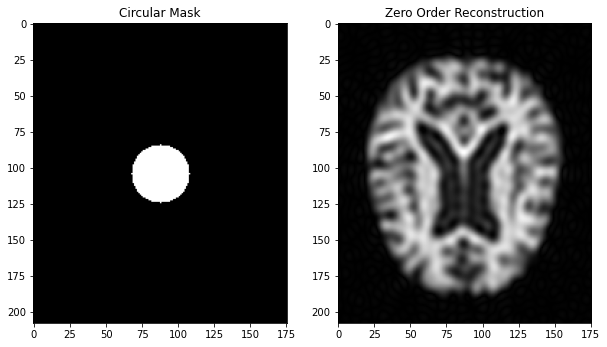

In [193]:
circ_mask = cv2.circle(np.zeros_like(image, dtype=np.uint8), (w//2, h//2), color=255, thickness=-1, radius=20)
masked_ft_4= fourier_transform*circ_mask
zero_ord_4= abs(ifft2(masked_ft_4))

fig, ax = plt.subplots(1, 2, figsize=(10,10))

ax[0].imshow(circ_mask, cmap='gray')
ax[0].set_title("Circular Mask")

ax[1].imshow(zero_ord_4, cmap='gray')
ax[1].set_title("Zero Order Reconstruction")


#### Periodic Sampling Procedure

In [194]:
def periodic_sampling_mask(height, width, spacing_factor=2, bands=8):
    factor= spacing_factor
    N= bands
    mask=np.zeros_like(image)
    for i in range(N):
        if i%2 == 0:
            repeater= np.concatenate((np.ones((1,width)), np.zeros((factor-1, width))), axis=0)
        else: 
            repeater= np.zeros((factor, width))
        tiling= (height//N)//factor
        tiled= np.tile(repeater, (tiling, 1))
        mask[i*tiled.shape[0]:(i+1)*tiled.shape[0]]= tiled
    return mask

In [196]:
mask_periodic_2= periodic_sampling_mask(h, w)
mask_periodic_4= periodic_sampling_mask(h, w, spacing_factor=4)
mask_periodic_8= periodic_sampling_mask(h, w, spacing_factor=6)

zero_ord_periodic_2= abs(ifft2(fourier_transform*mask_periodic_2))
zero_ord_periodic_4= abs(ifft2(fourier_transform*mask_periodic_4))
zero_ord_periodic_8= abs(ifft2(fourier_transform*mask_periodic_8))

Text(0.5, 1.0, 'Zero Order Reconstruction Periodic (8)')

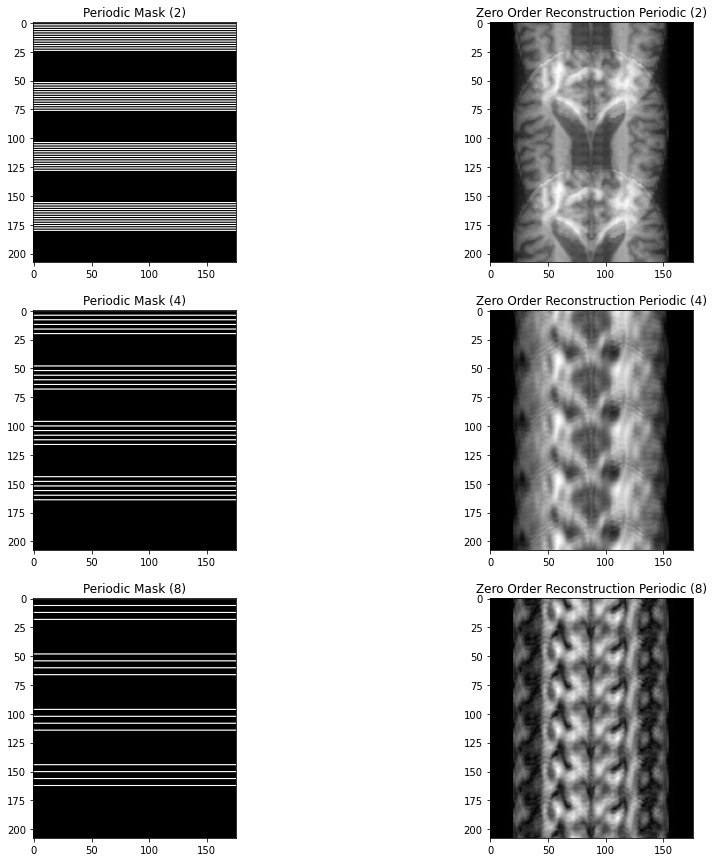

In [197]:
fig, ax = plt.subplots(3, 2, figsize=(15,15))

ax[0,0].imshow(mask_periodic_2, cmap='gray')
ax[0,0].set_title("Periodic Mask (2)")

ax[0,1].imshow(zero_ord_periodic_2, cmap='gray')
ax[0,1].set_title("Zero Order Reconstruction Periodic (2)")

ax[1,0].imshow(mask_periodic_4, cmap='gray')
ax[1,0].set_title("Periodic Mask (4)")

ax[1,1].imshow(zero_ord_periodic_4, cmap='gray')
ax[1,1].set_title("Zero Order Reconstruction Periodic (4)")

ax[2,0].imshow(mask_periodic_8, cmap='gray')
ax[2,0].set_title("Periodic Mask (8)")

ax[2,1].imshow(zero_ord_periodic_8, cmap='gray')
ax[2,1].set_title("Zero Order Reconstruction Periodic (8)")

#### Random Sampling Procedures

In [229]:
num_samples=h//2

mask_uniform= np.zeros_like(image)
indices_u= np.unique(sorted(np.random.randint(low=0, high=h, size=num_samples)))
mask_uniform[indices_u,:]=1

mask_gaussian= np.zeros_like(image)
indices_g= np.sort(np.clip(np.array(np.random.normal(loc=h//2, scale=h//8, size=num_samples), dtype='int'), 0, h))
mask_gaussian[indices_g, :]=1

zero_ord_uniform= abs(ifft2(fourier_transform*mask_uniform))
zero_ord_gaussian= abs(ifft2(fourier_transform*mask_gaussian))

Text(0.5, 1.0, 'Zero Order Reconstruction Gaussian')

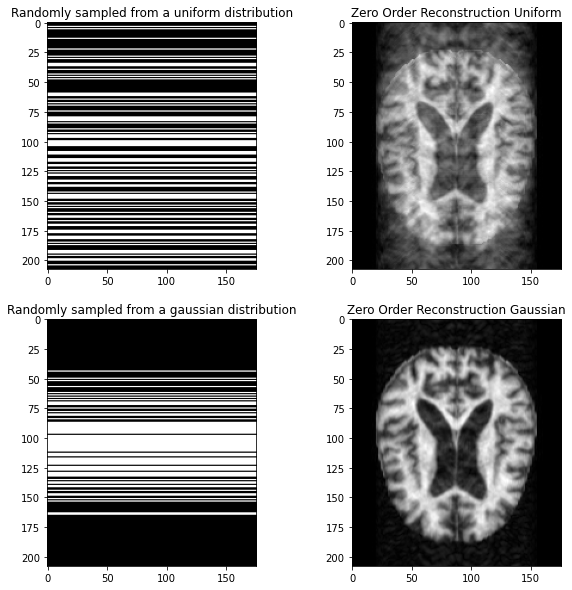

In [231]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

ax[0,0].imshow(mask_uniform, cmap='gray')
ax[0,0].set_title("Randomly sampled from a uniform distribution")

ax[0,1].imshow(zero_ord_uniform, cmap='gray')
ax[0,1].set_title("Zero Order Reconstruction Uniform")

ax[1,0].imshow(mask_gaussian, cmap='gray')
ax[1,0].set_title("Randomly sampled from a gaussian distribution")

ax[1,1].imshow(zero_ord_gaussian, cmap='gray')
ax[1,1].set_title("Zero Order Reconstruction Gaussian")


## Orthogonal Matching Pursuit

In [ ]:
m= 500
N= 10000
y= np.random.randn(m,1)
A= np.random.randn(m,N)

In [ ]:
res= omp(y, A, 500)
plt.stem(res)
print(res.shape)